# Extract an adata object for the use with squidpy

In [1]:
import os
import h5py
import numpy as np
import skimage
import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data_dir = '/home/icb/hannah.spitzer/projects/pelkmans/local_data/dataset_nikos/registered_hdf5'

In [3]:
# load one well, one position
well = 'C03'
pos = 1

dataset = h5py.File(os.path.join(data_dir, 'CellAtlas_{}_F{:03}.h5'.format(well, pos)), 'r')
mask = np.all(dataset['cell_segmentation'][:] > 0, axis=-1)
nuclei = np.all(dataset['nuclei_segmentation'][:] > 0, axis=-1)
cytoplasm = np.all(dataset['cytoplasm_segmentation'][:] > 0, axis=-1)
data = dataset['data'][:]

In [4]:
def get_proteins():
    # order of proteins from aar7042_Table_S1
    # for each "stain" folder, read DAPI, mouse, rabbit
    mouse = ['LAMP1','RAB11','TSG101','EGFR','HSP60','ABCD3','CCNE1','ISG15','c-MYC','EEA1','TFRC','VIME','p-FAK','GM130','CTNNB1','Actin','TUBA1A','NUPS','Yap/Taz','Climp63','VINC']
    rabbit = ['LC3B','p-ERK','p-AKT','p-AMPK','p-GSK3B','PKM2','EIF1a','GSK3A/B','CCNB1','p-RPS6','CAV1','p-4EBP1','SARA','p-MEK','CRT','PCNA','p-EGFR','PCNT','FBL','TGN46','p-ERK']
    proteins = []
    for i in range(72):
        if i % 3 == 0:
            # DAPI
            proteins.append('DAPI_{:02d}'.format(i//3+1))
        elif i % 3 == 1:
            # mouse
            if i//3 < len(mouse):
                proteins.append(mouse[i//3])
            else:
                proteins.append('mouse_{:02d}'.format(i//3+1))
        elif i % 3 == 2:
            # rabbit
            if i //3 < len(rabbit):
                proteins.append(rabbit[i//3])
            else:
                proteins.append('rabbit_{:02d}'.format(i//3+1))
    return proteins

In [5]:
# get and filter proteins (only use named proteins + only one DAPI stain (idx 0))
proteins = get_proteins()
protein_mask = [0,] + [i for i,p in enumerate(proteins) if ('mouse' not in p) and ('rabbit' not in p) and ('DAPI' not in p)]
print(len(protein_mask))

43


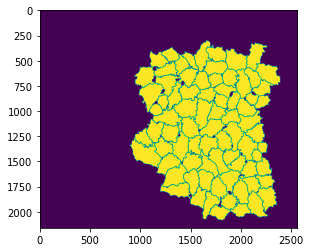

In [6]:
# create a mask for cells to make an adata with 
cell_labels = skimage.measure.label(mask)
cell_labels2 = skimage.measure.label(mask.T).T

cell_mask_lr = (cell_labels2 > 68)&(cell_labels2 < 199)&(cell_labels > 30)
plt.imshow(cell_mask_lr)

In [7]:
# size estimation
# addume float32
print(cell_mask_lr.sum()*len(protein_mask) / 1024 / 1024 * 4, "MB")

288.9851493835449 MB


In [8]:
# assemble adata
ys, xs = np.where(cell_mask_lr)
obs = pd.DataFrame({'x': xs, 'y': ys, 'is_nucleous': nuclei[ys,xs], 
              'is_cytplasm': cytoplasm[ys,xs], 'cell_id': cell_labels[ys,xs]})
var = pd.DataFrame(index=np.array(proteins)[protein_mask])
X = data[ys,xs][:,protein_mask]

In [9]:
adata = ad.AnnData(X, obs=obs, var=var)
adata.obsm['spatial'] = np.array([xs,ys]).T

/home/icb/hannah.spitzer/miniconda3/envs/pelkmans/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


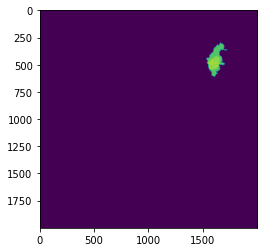

In [10]:
# check that data is ok but plotting one cell
sub_adata = adata[adata.obs['cell_id']==31]
arr = np.zeros((2000,2000))
arr[sub_adata.obs['y'],sub_adata.obs['x']] = sub_adata.X[:,0]
plt.imshow(arr)

In [ ]:
# looks good, save adata
adata.write('/storage/groups/ml01/datasets/raw/20201214_SquidpyData_giovanni.palla/4i/4i.h5ad')